<a href="https://colab.research.google.com/github/MaartenKool/Projects/blob/master/tensorflow_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow neural network regularization

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Regularization-with-penalty-term" data-toc-modified-id="Regularization-with-penalty-term-2">Regularization with penalty term</a></span></li><li><span><a href="#Regularization-with-dropout" data-toc-modified-id="Regularization-with-dropout-3">Regularization with dropout</a></span></li><li><span><a href="#Batch-normalization" data-toc-modified-id="Batch-normalization-4">Batch normalization</a></span><ul class="toc-item"><li><span><a href="#Activation-after-batch-normalization" data-toc-modified-id="Activation-after-batch-normalization-4.1">Activation after batch normalization</a></span></li><li><span><a href="#Activation-after-batch-normalization" data-toc-modified-id="Activation-after-batch-normalization-4.2">Activation after batch normalization</a></span></li></ul></li></ul></div>

Since the number of parameters in a neural network grows very fast with the number and width of the hidden layers, it is in general a good idea to apply some regularization strategy against overfitting. 

Typical methods for regularization are:

- Adding a penalty term to the loss function
- Applying dropout, i.e. during each epoch retaining only a fraction of the nodes

Further more we often find problems when fitting neural networks that model parameters grow suddenly out of bounds fast. This can be prevented by applying a technique known as batch normalization.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [0]:
import tensorflow as tf

In [0]:
def reset_graph(seed=1):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


def batch_iterator(X, y, batch_size):
    random_index = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_index in np.array_split(random_index, n_batches):
        X_batch, y_batch = X[batch_index], y[batch_index]
        yield X_batch, y_batch

## Load the data

In [0]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [0]:
df.drop(['class'], axis=1, inplace=True)
df.drop(['embark_town'], axis=1, inplace=True)
df.drop(['alive'], axis=1, inplace=True)
df['child'] = (df['who'] == 'child')*1

In [0]:
predictors = ['pclass', 'sex', 'fare', 'embarked', 'alone', 'child']

X = pd.get_dummies(df[predictors], columns=[
                   'pclass', 'sex', 'embarked', 'alone'], drop_first=True)
X = X.dropna()
X = X.values

In [0]:
y = df[['survived']].copy()
y['not_survived'] = (y['survived'] == 0)*1
y = y.values

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712, 2), (179, 2))

## Regularization with penalty term

The function to construct dense layers has an argument `kernel_regularizer` which we can set to

`tf.contrib.layers.l2_regularizer(scale)`

with some regularization strength `scale` (be careful, it needs to be a float) and similarly for `l1` or `l1_l2`. We then have to collect the regularization term and add it by hand to the loss function.

In [0]:
reset_graph()

n_train, n_input = X_train.shape
n_out = 2

n_hidden_1 = 4
n_hidden_2 = 4

layer_sizes = [n_input, n_hidden_1, n_hidden_2, n_out]

scale = 0.0001
kernel_regularizer = tf.contrib.layers.l2_regularizer(scale)

with tf.name_scope("variables") as scope:
    X = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
    Y = tf.placeholder(tf.int32, shape=[None, n_out], name='Y')


def multilayer_perceptron(x, layer_sizes):

    he_init = tf.variance_scaling_initializer()
    bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)

    layers = []
    layers.append(tf.layers.dense(
        x,
        layer_sizes[0],
        activation=tf.nn.relu,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))

    for i in range(1, len(layer_sizes)-1):
        layers.append(tf.layers.dense(
            layers[-1],
            layer_sizes[i],
            activation=tf.nn.relu,
            bias_initializer=bias_init,
            kernel_initializer=he_init,
            kernel_regularizer=kernel_regularizer))

    layers.append(tf.layers.dense(
        layers[-1],
        layer_sizes[-1],
        activation=None,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))

    return layers[-1]


with tf.name_scope("loss") as scope:
    # Have to collect penalty term and add to base loss
    predictions = multilayer_perceptron(X, layer_sizes)
    loss_base = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=predictions, labels=Y))
    loss_reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([loss_base] + loss_reg, name="loss")

    pred_labels = tf.argmax(predictions, 1)
    true_labels = tf.argmax(Y, 1)
    correct = tf.equal(pred_labels, true_labels)
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

with tf.name_scope("optimization") as scope:
    learning_rate = 0.01
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_operation = optimizer.minimize(loss)

training_epochs = 1000
display_step = 100
batch_size = 50
total_batch = int(n_train/batch_size)

loss_history = []
accuracy_history = []
loss_history_test = []
accuracy_history_test = []

init = tf.global_variables_initializer()
bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)
graph = tf.get_default_graph()

with tf.Session() as sess:

    sess.run(init)

    for epoch in range(training_epochs):

        loss_current, accuracy_current = sess.run(
            [loss, accuracy], feed_dict={X: X_train, Y: y_train})
        loss_history.append(loss_current)
        accuracy_history.append(accuracy_current)

        loss_current_test, accuracy_current_test = sess.run(
            [loss, accuracy], feed_dict={X: X_test, Y: y_test})
        loss_history_test.append(loss_current_test)
        accuracy_history_test.append(accuracy_current_test)

        if epoch % display_step == 0:
            print("Epoch: {}".format(epoch))
            print(" Training score: {:.3}".format(accuracy_current))

        for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
            sess.run(training_operation, feed_dict={X: X_batch, Y: y_batch})

        score_final, predictions_y = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_train, Y: y_train})
        coefs = sess.run(tf.get_default_graph(
        ).get_collection('trainable_variables'))

        score_test, predictions_test = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_test, Y: y_test})

    print("Score train: {:.4}, Score test: {:.4}".format(
        score_final, score_test))

Epoch: 0
 Training score: 0.66
Epoch: 100
 Training score: 0.855
Epoch: 200
 Training score: 0.857
Epoch: 300
 Training score: 0.861
Epoch: 400
 Training score: 0.862
Epoch: 500
 Training score: 0.867
Epoch: 600
 Training score: 0.861
Epoch: 700
 Training score: 0.864
Epoch: 800
 Training score: 0.858
Epoch: 900
 Training score: 0.871
Score train: 0.8652, Score test: 0.7598


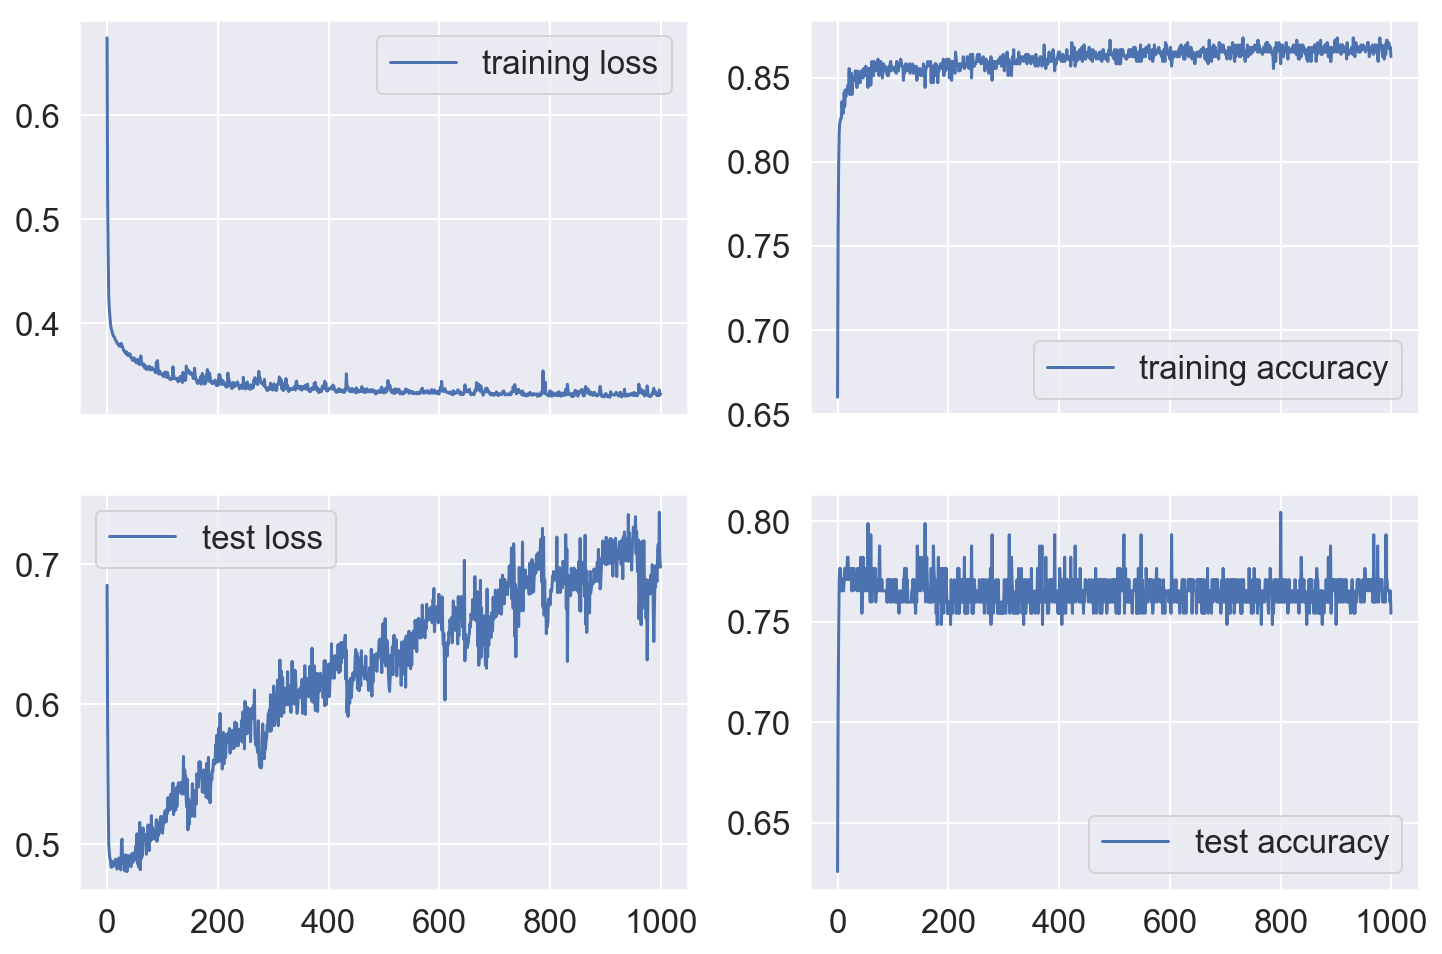

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)
ax[0, 0].plot(list(range(training_epochs)),
              loss_history, label='training loss')
ax[0, 0].legend()
ax[0, 1].plot(list(range(training_epochs)),
              accuracy_history, label='training accuracy')
ax[0, 1].legend()
ax[1, 0].plot(list(range(training_epochs)),
              loss_history_test, label='test loss')
ax[1, 0].legend()
ax[1, 1].plot(list(range(training_epochs)),
              accuracy_history_test, label='test accuracy')
ax[1, 1].legend()
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train[:, 1], predictions_y)

0.8651685393258427

In [0]:
coefs

[array([[-6.5701559e-02,  2.9714832e+00,  1.1177289e+00,  5.4613560e-01,
          1.1559590e+00, -4.4570473e-01,  1.8369629e+00, -1.9242072e+00],
        [ 7.8968954e-01,  3.1479973e-01, -3.2481602e-01, -1.9896844e-02,
         -3.8151196e-01,  9.6205586e-01, -1.3584799e+00, -1.5001178e+00],
        [ 9.7913682e-01,  5.2213019e-01,  7.3476416e-01,  4.2436659e-01,
          1.4086708e-01,  6.5836781e-01,  9.9878788e-02,  3.8311815e-01],
        [-1.4243307e+00,  4.4248807e-01,  9.3723029e-01, -2.6596637e-02,
          1.6328154e+00, -6.6825497e-01,  1.5600188e-01,  7.0589721e-01],
        [ 1.3523117e+00, -4.7677404e-01,  1.8995022e+00, -1.2229568e+00,
          8.7418348e-01, -4.2640957e-01, -4.4937548e-01,  1.0013856e+00],
        [ 1.3629372e+00, -3.9914346e-01,  9.2558700e-01, -3.9442533e-01,
         -6.1219823e-01, -4.3087304e-01,  2.3235936e-01, -8.1263030e-01],
        [ 6.5659791e-02,  1.0876889e+00, -3.1229004e-01, -5.8458090e-01,
         -1.5448666e-03,  8.4197086e-01,  8.3

In [0]:
import tfgraphviz as tfg

In [0]:
g = tfg.board(tf.get_default_graph())
g.view()

'G.gv.pdf'

## Regularization with dropout

In dropout, we discard in each epoch a fraction of the nodes and use only the remaining ones for adjustments of coefficients. We add the dropout as an additional operation after each layer except the output layer. When making predictions, we however use all the nodes and edge weights. 

Since the weights of each node are overestimated during the dropout stage, we have to rescale the model parameters for making predictions. Therefore we have to distinguish if we are at the fitting or at the prediction stage. We can do this by creating an indicator variable (here named `training`) with default value `False`, which however is turned to `True` when passed as an argument to the dropout function. We have to add the indicator variable also to the `feed_dict` when calling the training operation.

In [0]:
reset_graph()

n_train, n_input = X_train.shape
n_out = 2

n_hidden_1 = 4
n_hidden_2 = 4

layer_sizes = [n_input, n_hidden_1, n_hidden_2, n_out]

kernel_regularizer = None


with tf.name_scope("variables") as scope:
    X = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
    Y = tf.placeholder(tf.int32, shape=[None, n_out], name='Y')

training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate = 0.5


def multilayer_perceptron(x, layer_sizes):

    he_init = tf.variance_scaling_initializer()
    bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)

    layers = []
    layers.append(tf.layers.dense(
        x,
        layer_sizes[0],
        activation=tf.nn.relu,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))
    layers.append(tf.layers.dropout(
        layers[-1], dropout_rate, training=training))

    for i in range(1, len(layer_sizes)-1):
        layers.append(tf.layers.dense(
            layers[-1],
            layer_sizes[i],
            activation=tf.nn.relu,
            bias_initializer=bias_init,
            kernel_initializer=he_init,
            kernel_regularizer=kernel_regularizer))
        layers.append(tf.layers.dropout(
            layers[-1], dropout_rate, training=training))

    layers.append(tf.layers.dense(
        layers[-1],
        layer_sizes[-1],
        activation=None,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))

    return layers[-1]


with tf.name_scope("loss") as scope:
    predictions = multilayer_perceptron(X, layer_sizes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=predictions, labels=Y))

    pred_labels = tf.argmax(predictions, 1)
    true_labels = tf.argmax(Y, 1)
    correct = tf.equal(pred_labels, true_labels)
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

with tf.name_scope("optimization") as scope:
    learning_rate = 0.01
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_operation = optimizer.minimize(loss)

training_epochs = 1000
display_step = 100
batch_size = 50
total_batch = int(n_train/batch_size)

loss_history = []
accuracy_history = []
loss_history_test = []
accuracy_history_test = []


init = tf.global_variables_initializer()
bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)
graph = tf.get_default_graph()

with tf.Session() as sess:

    sess.run(init)

    for epoch in range(training_epochs):

        loss_current, accuracy_current = sess.run(
            [loss, accuracy], feed_dict={X: X_train, Y: y_train})
        loss_current_test, accuracy_current_test = sess.run(
            [loss, accuracy], feed_dict={X: X_test, Y: y_test})

        loss_history.append(loss_current)
        accuracy_history.append(accuracy_current)
        loss_history_test.append(loss_current_test)
        accuracy_history_test.append(accuracy_current_test)

        if epoch % display_step == 0:
            print("Epoch: {}".format(epoch))
            print(" Training score: {:.3}, Test score: {:.3}".format(
                accuracy_current, accuracy_current_test))

        for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
            # Add dropout indicator during training
            sess.run(training_operation, feed_dict={
                     training: True, X: X_batch, Y: y_batch})

        score_final, predictions_y = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_train, Y: y_train})
        coefs = sess.run(tf.get_default_graph(
        ).get_collection('trainable_variables'))

        score_test, predictions_test = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_test, Y: y_test})

    print("Score train: {:.4}, Score test: {:.4}".format(
        score_final, score_test))

Epoch: 0
 Training score: 0.378, Test score: 0.408
Epoch: 100
 Training score: 0.83, Test score: 0.765
Epoch: 200
 Training score: 0.84, Test score: 0.771
Epoch: 300
 Training score: 0.84, Test score: 0.782
Epoch: 400
 Training score: 0.817, Test score: 0.765
Epoch: 500
 Training score: 0.84, Test score: 0.777
Epoch: 600
 Training score: 0.837, Test score: 0.777
Epoch: 700
 Training score: 0.838, Test score: 0.782
Epoch: 800
 Training score: 0.823, Test score: 0.765
Epoch: 900
 Training score: 0.833, Test score: 0.771
Score train: 0.8399, Score test: 0.7765


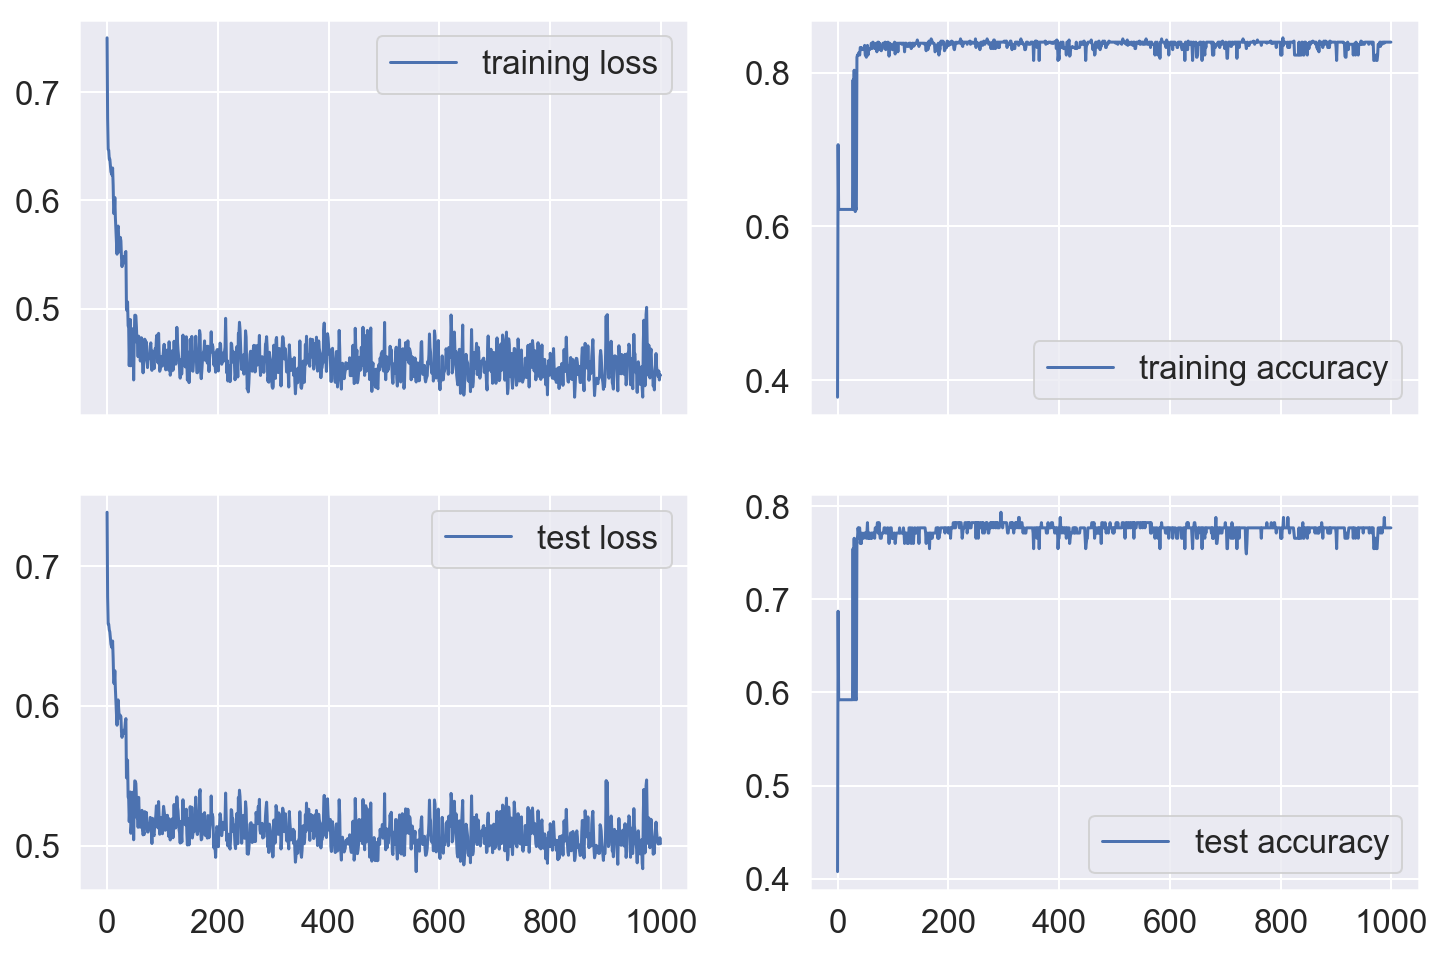

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)
ax[0, 0].plot(list(range(training_epochs)),
              loss_history, label='training loss')
ax[0, 0].legend()
ax[0, 1].plot(list(range(training_epochs)),
              accuracy_history, label='training accuracy')
ax[0, 1].legend()
ax[1, 0].plot(list(range(training_epochs)),
              loss_history_test, label='test loss')
ax[1, 0].legend()
ax[1, 1].plot(list(range(training_epochs)),
              accuracy_history_test, label='test accuracy')
ax[1, 1].legend()
plt.show()

In [0]:
g = tfg.board(tf.get_default_graph())
g.view()

'G.gv.pdf'

In [0]:
coefs

[array([[-0.73642194, -1.3662869 ,  0.0792807 , -0.08961551,  0.4083832 ,
         -0.23605476,  0.36812767, -0.30189914],
        [-0.93098575, -1.1084411 ,  0.8513446 ,  0.61423403,  0.06651766,
          0.9126485 , -0.94523674, -0.8311134 ],
        [ 0.93411833,  1.0239588 ,  0.02565335, -0.06784832, -0.02984984,
         -0.31952235, -0.30778328,  0.6257974 ],
        [ 1.0670005 ,  0.7980342 , -2.2571337 , -2.060194  , -1.2709117 ,
         -2.142878  , -1.1207101 ,  1.2457653 ],
        [ 1.6286021 ,  1.793643  , -1.1833532 , -1.4718578 , -2.1328955 ,
         -0.9260707 , -1.9799657 ,  1.9853909 ],
        [ 0.7972092 ,  0.30953   ,  0.11667699,  0.6735351 ,  0.23165196,
         -0.17146626,  0.2345489 ,  0.71907026],
        [ 0.7637216 , -0.0593357 , -0.2705392 , -0.35786963, -0.37894055,
         -0.5129678 , -0.12023231,  0.37738335],
        [-0.30099744, -0.5829128 ,  0.03483392,  0.0636536 ,  0.02786435,
         -0.1090198 ,  0.07938547, -0.620803  ]], dtype=float32),

## Batch normalization

Typical gradient descent methods used for coefficient updates look only at first order corrections to improve the loss function, neglecting important dependencies among the coefficients. As a result, parameters either hardly change from iteration step to iteration step, making training very slow (vanishing gradients problem) or small corrections to each of the coefficients can lead to dramatic blow ups and overflow (exploding gradients problem). Batch normalization tries to avoid this issue by reparametrizing the coefficients. During each mini-batch, the mean and standard deviation over all inputs are used to standardize them. Batch normalization can be combined with regularization. 

We can easily implement this procedure by inserting 

`tf.layers.batch_normalization`

applied to the preceding layer after each layer. You will find debates if batch normalization should be applied before making use of the activation function or afterwards. We can easily try out both. Either just insert the function after the layer as it was,
or use the layer creation function with `activation=None` and apply the activation function to the result of the batch normalization for example with `tf.nn.relu`. 

Note that in order to make batch normalization be applied correctly, we have to wrap the command

`extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_ops):`
 
around the training operation and use the indicator variable `training`.

### Activation after batch normalization

In [0]:
reset_graph()

n_train, n_input = X_train.shape
n_out = 2

n_hidden_1 = 4
n_hidden_2 = 4

layer_sizes = [n_input, n_hidden_1, n_hidden_2, n_out]

kernel_regularizer = None

with tf.name_scope("variables") as scope:
    X = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
    Y = tf.placeholder(tf.int32, shape=[None, n_out], name='Y')

training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate = 0.5


def multilayer_perceptron(x, layer_sizes):

    he_init = tf.variance_scaling_initializer()
    bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)

    layers = []
    layers.append(tf.layers.dense(
        x,
        layer_sizes[0],
        activation=tf.nn.relu,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))
    layers.append(tf.layers.batch_normalization(
        layers[-1], training=training, momentum=0.99))
    layers.append(tf.layers.dropout(
        layers[-1], dropout_rate, training=training))

    for i in range(1, len(layer_sizes)-1):
        layers.append(tf.layers.dense(
            layers[-1],
            layer_sizes[i],
            activation=tf.nn.relu,
            bias_initializer=bias_init,
            kernel_initializer=he_init,
            kernel_regularizer=kernel_regularizer))
        layers.append(tf.layers.batch_normalization(
            layers[-1], training=training, momentum=0.99))
        layers.append(tf.layers.dropout(
            layers[-1], dropout_rate, training=training))

    layers.append(tf.layers.dense(
        layers[-1],
        layer_sizes[-1],
        activation=None,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))
    layers.append(tf.layers.batch_normalization(
        layers[-1], training=training, momentum=0.99))

    return layers[-1]


with tf.name_scope("loss") as scope:
    predictions = multilayer_perceptron(X, layer_sizes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=predictions, labels=Y))

    pred_labels = tf.argmax(predictions, 1)
    true_labels = tf.argmax(Y, 1)
    correct = tf.equal(pred_labels, true_labels)
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

with tf.name_scope("optimization") as scope:
    # add the following lines to activate batch normalization
    extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_ops):
        learning_rate = 0.01
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_operation = optimizer.minimize(loss)

training_epochs = 1000
display_step = 100
batch_size = 50
total_batch = int(n_train/batch_size)

loss_history = []
accuracy_history = []
loss_history_test = []
accuracy_history_test = []


init = tf.global_variables_initializer()
bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)
graph = tf.get_default_graph()

with tf.Session() as sess:

    sess.run(init)

    for epoch in range(training_epochs):

        loss_current, accuracy_current = sess.run(
            [loss, accuracy], feed_dict={X: X_train, Y: y_train})
        loss_current_test, accuracy_current_test = sess.run(
            [loss, accuracy], feed_dict={X: X_test, Y: y_test})

        loss_history.append(loss_current)
        accuracy_history.append(accuracy_current)
        loss_history_test.append(loss_current_test)
        accuracy_history_test.append(accuracy_current_test)

        if epoch % display_step == 0:
            print("Epoch: {}".format(epoch))
            print(" Training score: {:.3}, Test score: {:.3}".format(
                accuracy_current, accuracy_current_test))

        for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
            sess.run(training_operation, feed_dict={
                     training: True, X: X_batch, Y: y_batch})

        score_final, predictions_y = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_train, Y: y_train})
        coefs = sess.run(tf.get_default_graph(
        ).get_collection('trainable_variables'))

        score_test, predictions_test = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_test, Y: y_test})

    print("Score train: {:.4}, Score test: {:.4}".format(
        score_final, score_test))

Epoch: 0
 Training score: 0.586, Test score: 0.531
Epoch: 100
 Training score: 0.838, Test score: 0.771
Epoch: 200
 Training score: 0.841, Test score: 0.777
Epoch: 300
 Training score: 0.837, Test score: 0.765
Epoch: 400
 Training score: 0.84, Test score: 0.777
Epoch: 500
 Training score: 0.823, Test score: 0.765
Epoch: 600
 Training score: 0.823, Test score: 0.765
Epoch: 700
 Training score: 0.84, Test score: 0.777
Epoch: 800
 Training score: 0.84, Test score: 0.771
Epoch: 900
 Training score: 0.838, Test score: 0.771
Score train: 0.8399, Score test: 0.7709


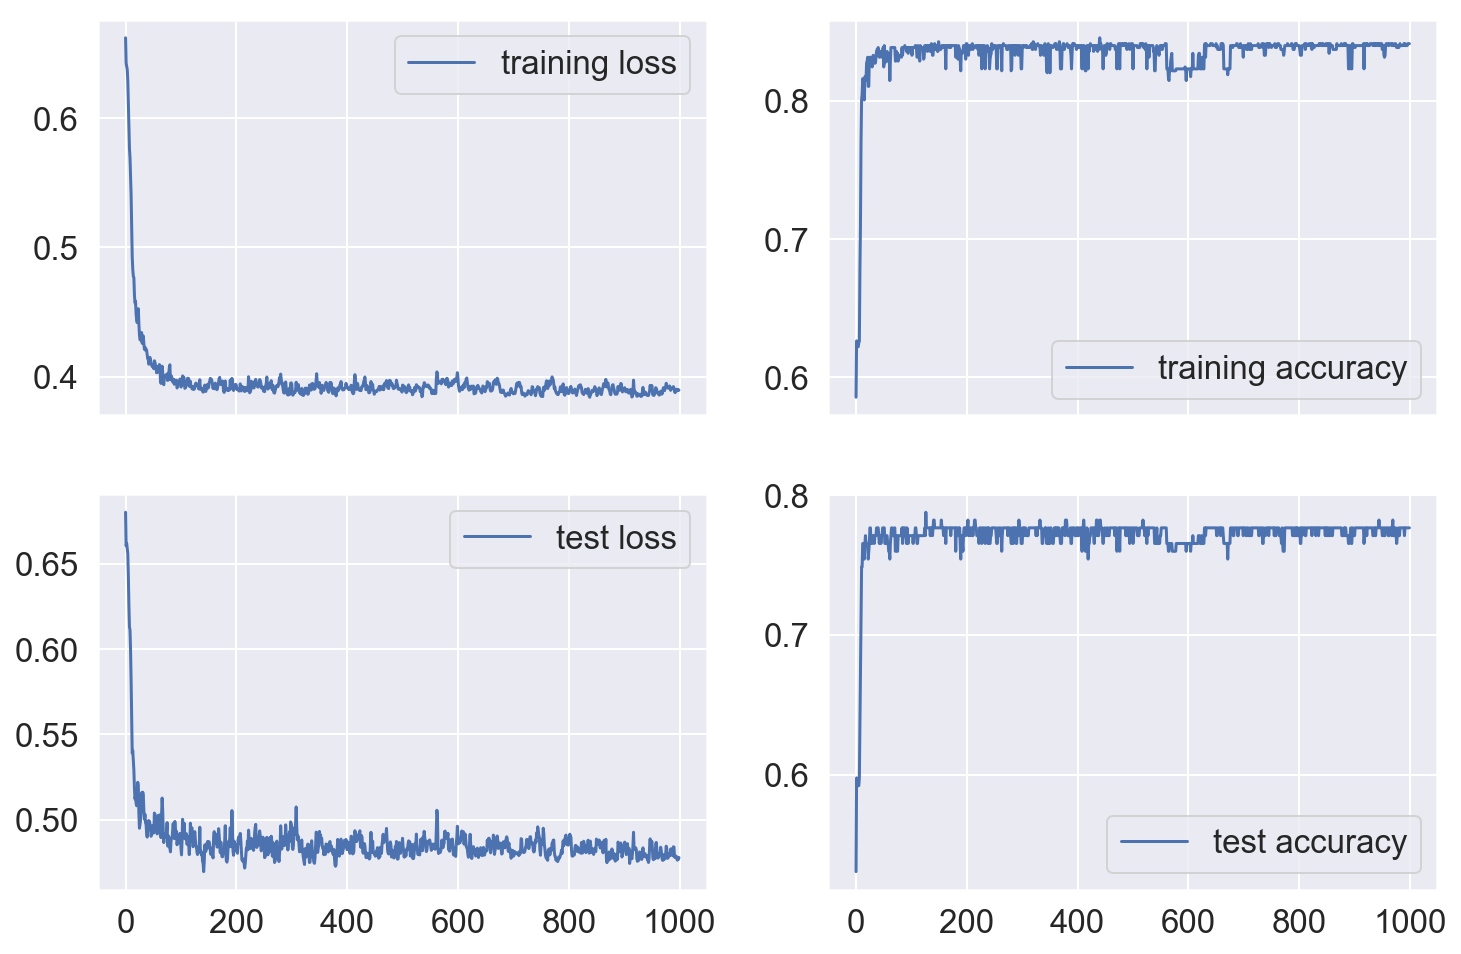

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)
ax[0, 0].plot(list(range(training_epochs)),
              loss_history, label='training loss')
ax[0, 0].legend()
ax[0, 1].plot(list(range(training_epochs)),
              accuracy_history, label='training accuracy')
ax[0, 1].legend()
ax[1, 0].plot(list(range(training_epochs)),
              loss_history_test, label='test loss')
ax[1, 0].legend()
ax[1, 1].plot(list(range(training_epochs)),
              accuracy_history_test, label='test accuracy')
ax[1, 1].legend()
plt.show()

In [0]:
g = tfg.board(tf.get_default_graph())
g.view()

'G.gv.pdf'

These are the operations that we have to wrap around the optimizer.

In [0]:
graph.get_all_collection_keys()

['variables', 'trainable_variables', 'update_ops', 'cond_context', 'train_op']

In [0]:
graph.get_collection('update_ops')

[<tf.Operation 'loss/batch_normalization/cond_2/Merge' type=Merge>,
 <tf.Operation 'loss/batch_normalization/cond_3/Merge' type=Merge>,
 <tf.Operation 'loss/batch_normalization_1/cond_2/Merge' type=Merge>,
 <tf.Operation 'loss/batch_normalization_1/cond_3/Merge' type=Merge>,
 <tf.Operation 'loss/batch_normalization_2/cond_2/Merge' type=Merge>,
 <tf.Operation 'loss/batch_normalization_2/cond_3/Merge' type=Merge>,
 <tf.Operation 'loss/batch_normalization_3/cond_2/Merge' type=Merge>,
 <tf.Operation 'loss/batch_normalization_3/cond_3/Merge' type=Merge>]

### Activation after batch normalization

Now try out to implement batch normalization before applying the activation function.

In [0]:
layers.append(tf.layers.batch_normalization(
        layers[-1], training=training, momentum=0.99))
        
        
        reset_graph()

n_train, n_input = X_train.shape
n_out = 2

n_hidden_1 = 4
n_hidden_2 = 4

layer_sizes = [n_input, n_hidden_1, n_hidden_2, n_out]

kernel_regularizer = None

with tf.name_scope("variables") as scope:
    X = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
    Y = tf.placeholder(tf.int32, shape=[None, n_out], name='Y')

training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate = 0.5


def multilayer_perceptron(x, layer_sizes):

    he_init = tf.variance_scaling_initializer()
    bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)

    layers = []
    layers.append(tf.layers.dense(
        x,
        layer_sizes[0],
        activation=tf.nn.relu,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))
    layers.append(tf.layers.batch_normalization(
        layers[-1], training=training, momentum=0.99))
    layers.append(tf.layers.dropout(
        layers[-1], dropout_rate, training=training))

    for i in range(1, len(layer_sizes)-1):
        layers.append(tf.layers.dense(
            layers[-1],
            layer_sizes[i],
            activation=tf.nn.relu,
            bias_initializer=bias_init,
            kernel_initializer=he_init,
            kernel_regularizer=kernel_regularizer))
        layers.append(tf.layers.batch_normalization(
            layers[-1], training=training, momentum=0.99))
        layers.append(tf.layers.dropout(
            layers[-1], dropout_rate, training=training))

    layers.append(tf.layers.dense(
        layers[-1],
        layer_sizes[-1],
        activation=None,
        bias_initializer=bias_init,
        kernel_initializer=he_init,
        kernel_regularizer=kernel_regularizer))
    layers.append(tf.layers.batch_normalization(
        layers[-1], training=training, momentum=0.99))

    return layers[-1]


with tf.name_scope("loss") as scope:
    predictions = multilayer_perceptron(X, layer_sizes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=predictions, labels=Y))

    pred_labels = tf.argmax(predictions, 1)
    true_labels = tf.argmax(Y, 1)
    correct = tf.equal(pred_labels, true_labels)
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

with tf.name_scope("optimization") as scope:
    # add the following lines to activate batch normalization
    extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_ops):
        learning_rate = 0.01
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_operation = optimizer.minimize(loss)

training_epochs = 1000
display_step = 100
batch_size = 50
total_batch = int(n_train/batch_size)

loss_history = []
accuracy_history = []
loss_history_test = []
accuracy_history_test = []


init = tf.global_variables_initializer()
bias_init = tf.random_normal_initializer(mean=0.1, stddev=0.3)
graph = tf.get_default_graph()

with tf.Session() as sess:

    sess.run(init)

    for epoch in range(training_epochs):

        loss_current, accuracy_current = sess.run(
            [loss, accuracy], feed_dict={X: X_train, Y: y_train})
        loss_current_test, accuracy_current_test = sess.run(
            [loss, accuracy], feed_dict={X: X_test, Y: y_test})

        loss_history.append(loss_current)
        accuracy_history.append(accuracy_current)
        loss_history_test.append(loss_current_test)
        accuracy_history_test.append(accuracy_current_test)

        if epoch % display_step == 0:
            print("Epoch: {}".format(epoch))
            print(" Training score: {:.3}, Test score: {:.3}".format(
                accuracy_current, accuracy_current_test))

        for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
            sess.run(training_operation, feed_dict={
                     training: True, X: X_batch, Y: y_batch})

        score_final, predictions_y = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_train, Y: y_train})
        coefs = sess.run(tf.get_default_graph(
        ).get_collection('trainable_variables'))

        score_test, predictions_test = sess.run(
            [accuracy, pred_labels], feed_dict={X: X_test, Y: y_test})

    print("Score train: {:.4}, Score test: {:.4}".format(
        score_final, score_test))